In [61]:
import pandas as pd
from scipy import special, integrate
import numpy as np
from yahoo_fin import options
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from datetime import datetime

In [62]:
plt.style.use('fivethirtyeight')

In [63]:
global dist_type
global theta
global sigma
global kappa
global mu
global r
global T
global S
global c_mkt
global K
global bid

This function will return the characteristic function of the distribution being used. The function has been written in this way to make the function reusable by simply passing the type argument to choose the required distribution

In [64]:
def CharFunc(u, params, type, dt):

    if type == 1: # Gaussian distribution
        mu, sigma = params[0], params[1]
        return np.exp(dt*(1j * u * mu - 0.5 * (sigma**2) * (u**2)))
    elif type == 2: # Variance Gamma distribution
        mu, theta, sigma, kappa = params[0], params[1], params[2], params[3]
        return np.exp(1j * u * mu * dt) * (1 - 1j * u * theta * kappa + 0.5 * (u**2) * (sigma**2) * kappa) ** (-dt / kappa)
    elif type == 3: # Normal inverse Gaussian distribution
        mu, theta, sigma, kappa = params[0], params[1], params[2], params[3]
        return np.exp(1j * u * mu * dt + dt/kappa * (1 - np.sqrt(1 + (u**2) * (sigma**2) * kappa - 2 * 1j * u * theta * kappa)))
    elif type == 4: # CGMY distribution
        mu, C, G, M, Y = params[0], params[1], params[2], params[3], params[4]
        return np.exp(1j * u * mu * dt + C * special.gamma(-Y) * dt * ((M - 1j * u) ** Y - (M**Y) + (G + 1j * u) ** Y - (G**Y)))
    elif type == 5: # Merton Jump Diffusion
        mu, sigma, l, mu_z, sigma_z = params[0], params[1], params[2], params[3], params[4]
        phi_Y = np.exp(1j * u * mu_z - 0.5 * (sigma_z**2) * (u**2))
        return np.exp(dt * (1j * u * mu - 0.5 * (sigma**2) * (u**2)) + l * (phi_Y - 1))
    elif type == 6: # Kou Jump Diffusion
        mu, sigma, l, p, eta1, eta2 = params[0], params[1], params[2], params[3], params[4], params[5]
        q = 1 - p
        phi_Y = p * eta1/(eta1 * 1j * u) + q * eta2/(eta2 * 1j * u)
        return np.exp(dt * (1j * u * mu - 0.5 * (sigma**2) * (u**2)) + l * (phi_Y - 1))
    elif type == 7: # Heston
        mu, sigma, k, neta, theta, rho = params[0], params[1], params[2], params[3], params[4], params[5]
        d = ((rho * theta * u * 1j - k)**2 - (theta**2) * (-1j * u - (u**2))) ** 0.5
        rep = k - rho * theta * u * 1j - d
        g = rep/(rep + 2 * d)
        tmp1 = np.exp(1j * u * mu * dt)
        tmp2 = np.exp(neta * k * (theta**-2) * (rep * dt - 2 * np.log((1 - g * np.exp(-d * dt))/(1 - g))))
        tmp3 = np.exp(sigma * (theta**-2) * rep * (1 - np.exp(-d * dt))/(1 - g * np.exp(-d * dt)))
        return tmp1 * tmp2 * tmp3

The function below returns the fourier transform of the call option which will be used to evaluate the price of a call option. The fourier transform of a call option is $\frac{K^{1 - R - iu}}{(1 - R - iu)(-R - iu)}$

In [65]:
def call_option_transform(u, K, R):
    return (K ** (1 - R - 1j * u))/((1 - R - 1j * u) * (- R - 1j * u))

Ticker used below is AAPL but that can be changed to anything else for which data is available

In [66]:
tick = 'AAPL'
exp_date = options.get_expiration_dates(tick)[0]
calls = pd.DataFrame()
calls = options.get_calls(tick)
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Contract Name       45 non-null     object 
 1   Last Trade Date     45 non-null     object 
 2   Strike              45 non-null     float64
 3   Last Price          45 non-null     float64
 4   Bid                 45 non-null     float64
 5   Ask                 45 non-null     float64
 6   Change              45 non-null     float64
 7   % Change            45 non-null     object 
 8   Volume              45 non-null     object 
 9   Open Interest       45 non-null     int64  
 10  Implied Volatility  45 non-null     object 
dtypes: float64(5), int64(1), object(5)
memory usage: 4.0+ KB


The unwanted columns are removed and the implied volatility ($\sigma_{imp}$) is converted to a more suitable format

In [67]:
calls['Implied Volatility'] = calls['Implied Volatility'].str.replace('%', '').astype(float)/100
calls = calls.drop(['Contract Name', 'Last Trade Date', 'Last Price', 'Ask', 'Change', '% Change', 'Volume', 'Open Interest'], axis=1)

The below 2 functions are used to extract the implied risk free rate. This is done using a minimizer and taking the sum of squared errors between the bid price and the calculated price. The assumption here is that the implied volatility is for the bid prices.

In [68]:
def BSCall(S,K,r,T,sigma):
    d1 = ( (np.log(S/K)+(r+0.5*sigma**2)*T) / (sigma*np.sqrt(T)) )
    d2 = ( (np.log(S/K)+(r-0.5*sigma**2)*T) / (sigma*np.sqrt(T)) )
    BSCall = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    return BSCall

In [69]:
def impliedrfr(r):
    for i in range(calls.shape[0]):
        calls.loc[i, 'Calculated Price'] = BSCall(S, calls.loc[i, 'Strike'], r, T, calls.loc[i, 'Implied Volatility'])
    sse = ((bid - calls['Calculated Price']) ** 2).sum()
    return sse

In [70]:
stock = yf.Ticker(tick)
price = stock.history(period='1d')
S = price['Close'][0]
r = 0.05
T = (datetime.strptime(exp_date, '%B %d, %Y') - datetime.today()).days/366
bid = calls['Bid']

res1 = minimize(impliedrfr, x0=r)
r = res1['x']
r

array([-0.02181804])

The function below is where the fourier price is obtained using the methodology outlined by Eberlein, Glau, and Papapantoleon (2010). They state that the price of a call option can be calculated as follows

$C_{o}(s) = e^{-rT}\frac{e^{-Rs}}{\pi}\int_0^\infty Re(e^{-ius}\phi_{X_{t}}(u - iR)\hat C_{t}(iR - u))du$

where $s = -\log S_{o}$, $\hat C_{t}(u)$ is the fourier transform of the call option payoff, $\phi_{X_{t}}(u)$ is the fourier transform of the distribution used, $X_{t} = \log S_{t} - s$. The parameter R is taken to be 1.1 but the condition here is that it must be strictly greater than 1 to ensure integrability.

In [71]:
def fourier_pricing(type, params, K, S, r, T):
    R = 1.1
    s = -np.log(S)
    q = 0
    if type == 7:
        omega = 0
    else:
        omega = np.log(CharFunc(-1j, params, type, T))

    mu = r - q - omega
    params[0] = mu

    c_mod = pd.Series()
    for i in range(calls.shape[0]):
        c_mod.loc[i] = np.exp(-r * T) * np.exp(-R * s)/np.pi * integrate.quad(lambda u: (np.exp(-1j * u * s) * 
                                                                                        CharFunc(u - 1j * R, params, type, T) * 
                                                                                        call_option_transform(u, K.iloc[i], R)).real, 
                                                                                        0, np.inf)[0]
    return c_mod

In [72]:
def objective_function(init_guess):
    theta, sigma, kappa = init_guess
    c_mod = fourier_pricing(dist_type, [mu, theta, sigma, kappa], K, S, r, T)
    sse = ((c_mkt - c_mod)**2).sum()
    return sse

The initial guess for theta of the Normal Inverse Gaussian distribution is negative since equities have a negative skew. There is no particular reason this distribution was chosen.

In [73]:
dist_type = 3
theta = -0.3
sigma = 0.2
kappa = 0.4
mu = 0
init_guess = [theta, sigma, kappa]
c_mkt = calls['Bid']
K = calls['Strike']

res = minimize(objective_function, x0=init_guess, method='Nelder-Mead')
print(res)

/var/folders/rk/7xsp5tcd2hlg9cvhq74cfnq00000gn/T/ipykernel_4281/2176318434.py:15: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  c_mod.loc[i] = np.exp(-r * T) * np.exp(-R * s)/np.pi * integrate.quad(lambda u: (np.exp(-1j * u * s) *


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.38626841342039697
             x: [-3.606e-02  2.733e-01  7.197e-03]
           nit: 106
          nfev: 193
 final_simplex: (array([[-3.606e-02,  2.733e-01,  7.197e-03],
                       [-3.610e-02,  2.734e-01,  7.263e-03],
                       [-3.596e-02,  2.733e-01,  7.168e-03],
                       [-3.607e-02,  2.733e-01,  7.242e-03]]), array([ 3.863e-01,  3.863e-01,  3.863e-01,  3.863e-01]))


The figure below shows the bid price obtained from the data source and the price from the calibrated model. They appear to match indicating that the calibration was a success. A deeper look into the absolute and percentage errors will tell us if that is really the case.

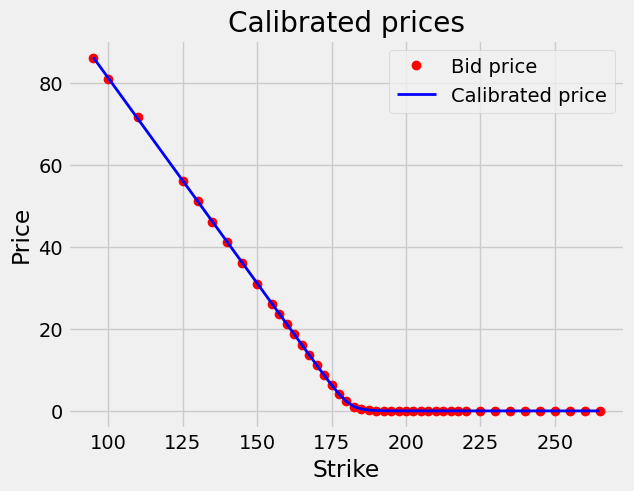

In [74]:
theta, sigma, kappa = res['x']
calls['calib_prices'] = fourier_pricing(dist_type, [mu, theta, sigma, kappa], K, S, r, T)
plt.plot(calls['Strike'], calls['Bid'], 'o r')
plt.plot(calls['Strike'], calls['calib_prices'], '-b', linewidth=2)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Calibrated prices')
plt.legend(['Bid price', 'Calibrated price'])
plt.show()

It appears that the calibration wasn't able to correctly estimate prices of at the money option. 

This exercise only uses the volatility curve of one maturity rather than the entire volatility surface. The code can be extended to account for the entire surface leading to a better estimate of prices however, due to computational limitations, that won't be done here.

In [79]:
calls['Absolute error'] = calls['Bid'] - calls['calib_prices']
calls['Percentage errors'] = (calls['Bid'] - calls['calib_prices'])/calls['calib_prices'] * 100
calls

,Strike,Bid,Implied Volatility,calib_prices,Absolute error,Percentage errors
0,95.0,86.00,2.3516,[86.14491121624215],[-0.14491121624214998],[-0.16821796458573374]
1,100.0,81.00,2.0313,[81.14401666612459],[-0.1440166661245854],[-0.1774827917591963]
2,110.0,71.65,2.4316,[71.14222835613674],[0.5077716438632649],[0.7137415506882481]
3,125.0,56.10,1.5000,[56.1395455835204],[-0.039545583520400385],[-0.07044158108042983]
4,130.0,51.05,1.3281,[51.13865135040544],[-0.08865135040544203],[-0.17335488532538154]
5,135.0,46.05,1.1953,[46.137757353504],[-0.08775735350400282],[-0.1902072370609881]
6,140.0,41.05,1.0645,[41.13686443561137],[-0.0868644356113748],[-0.21115959323379538]
7,145.0,36.05,0.9375,[36.13597760216216],[-0.08597760216215988],[-0.23792798166062484]
8,150.0,31.05,0.8145,[31.13512300572381],[-0.08512300572380838],[-0.27339864919807627]
9,155.0,26.05,0.7109,[26.13443564729625],[-0.08443564729624953],[-0.32308196142350926]
